In [1]:
!pip install kagglehub

import kagglehub

# Download the TESS dataset
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/toronto-emotional-speech-set-tess


In [2]:
import os
import pandas as pd

# Base path where your dataset is located
base_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data"

file_paths = []
file_emotions = []

# Loop through all subdirectories
for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".wav"):
                full_path = os.path.join(folder_path, filename)
                file_paths.append(full_path)

                # Extract emotion from filename
                emotion = filename.split('_')[-1].replace('.wav', '').lower()
                if 'ps' in emotion or 'pleasant' in emotion:
                    file_emotions.append('surprise')
                else:
                    file_emotions.append(emotion)

# Create the final DataFrame
tess_df = pd.DataFrame({
    'Path': file_paths,
    'Emotions': file_emotions
})

# Check top few entries
tess_df.head()


,Path,Emotions
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


<ipython-input-3-ae54e43cb2f4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Emotions', data=tess_df, order=tess_df['Emotions'].value_counts().index, palette="muted")


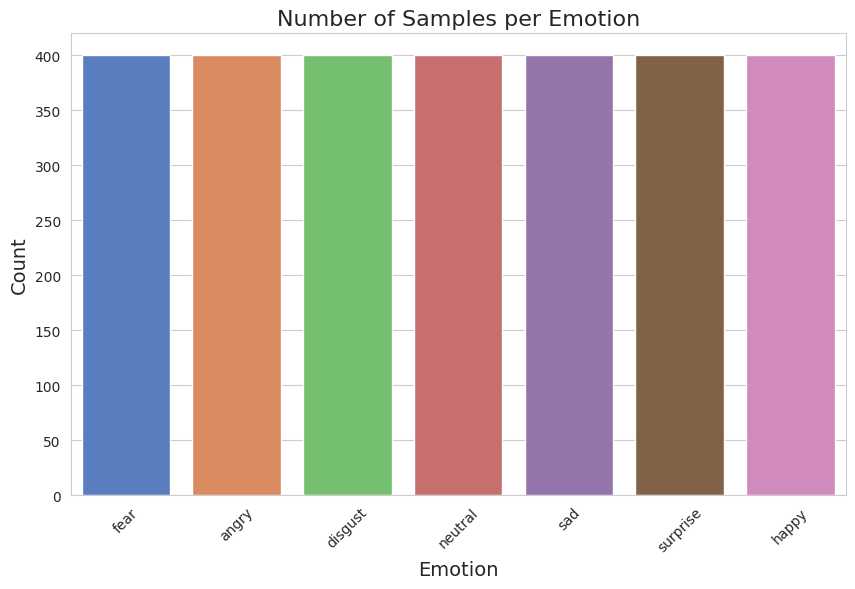

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

# Plot the count of each emotion
sns.countplot(x='Emotions', data=tess_df, order=tess_df['Emotions'].value_counts().index, palette="muted")

# Title and labels
plt.title("Number of Samples per Emotion", fontsize=16)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.show()


In [4]:
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Lists to store features and labels
X = []
y = []

# Set desired MFCC parameters
n_mfcc = 40       # Number of MFCCs
max_len = 216     # Fixed number of frames (you can change this based on average length)

for i in tqdm(range(len(tess_df))):
    file_path = tess_df['Path'][i]
    emotion = tess_df['Emotions'][i]

    # Load audio file
    audio, sample_rate = librosa.load(file_path, sr=None)

    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

    # Pad or truncate MFCCs to fixed length
    if mfccs.shape[1] < max_len:
        pad_width = max_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0,0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]

    X.append(mfccs)
    y.append(emotion)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("MFCCs shape:", X.shape)
print("Labels shape:", y.shape)


100%|██████████| 2800/2800 [01:26<00:00, 32.19it/s]


MFCCs shape: (2800, 40, 216)
Labels shape: (2800,)


In [5]:
import librosa
import numpy as np

# ------------ Data Augmentation Helpers ------------

def noise(data):
    noise_amp = 0.005 * np.random.uniform() * np.amax(data)
    return data + noise_amp * np.random.normal(size=data.shape[0])

def stretch(data, sample_rate, rate=0.8):
    # librosa.effects.time_stretch expects a tuple (y, sr) in the current version
    # Pass only the data, not the tuple to time_stretch
    return librosa.effects.time_stretch(data, rate=rate) # Changed line

def pitch(data, sr, steps=2):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=steps)

# ------------ Feature Extraction ------------

def extract_features(data, sample_rate):
    result = np.array([])

    # Zero Crossing Rate
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Chroma STFT
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc))

    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result

# ------------ Combine All Augmented Features ------------

def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Original
    orig_features = extract_features(data, sample_rate)

    # Noise
    noise_data = noise(data)
    noise_features = extract_features(noise_data, sample_rate)

    # Stretch + Pitch Shift
    stretched_data = stretch(data, sample_rate) # Pass sample_rate to stretch
    pitch_data = pitch(stretched_data, sample_rate)
    pitch_features = extract_features(pitch_data, sample_rate)

    # Stack vertically (each is 1D)
    final_result = np.vstack([orig_features, noise_features, pitch_features])

    return final_result

In [6]:
X = []
y = []

for i in tqdm(range(len(tess_df))):
    path = tess_df['Path'][i]
    emotion = tess_df['Emotions'][i]

    features = get_features(path)
    for row in features:
        X.append(row)
        y.append(emotion)

X = np.array(X)
y = np.array(y)


100%|██████████| 2800/2800 [08:08<00:00,  5.74it/s]


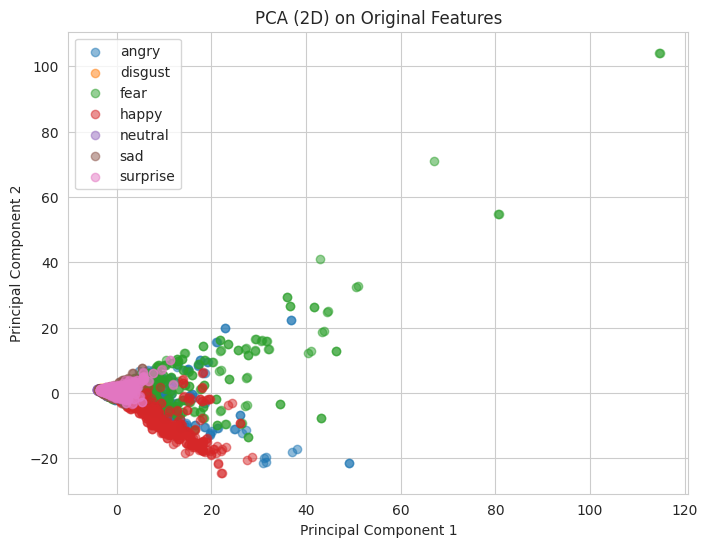

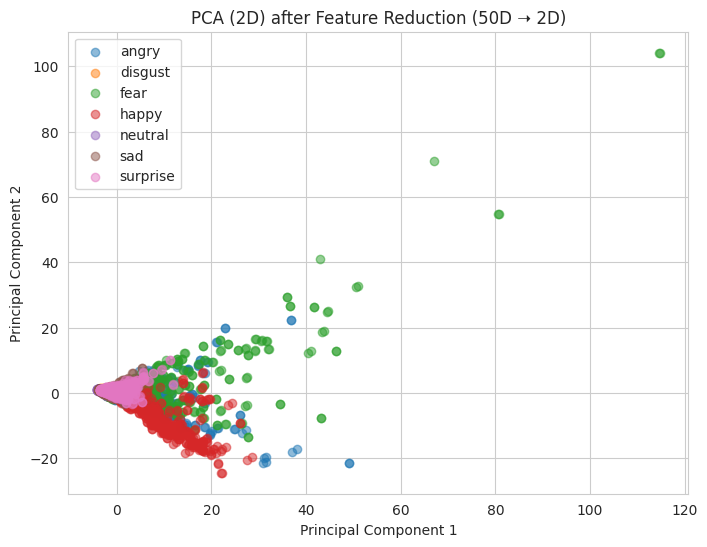

In [11]:
import matplotlib.pyplot as plt

# Reduce to 2D just for visualization
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for emotion in np.unique(y):
    idx = np.where(y == emotion)
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=emotion, alpha=0.5)

plt.title("PCA (2D) on Original Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()

# Reduce PCA features (already 50D) down to 2D for plotting
pca_vis = PCA(n_components=2)
X_pca_2d = pca_vis.fit_transform(X_pca)

plt.figure(figsize=(8, 6))
for emotion in np.unique(y):
    idx = np.where(y == emotion)
    plt.scatter(X_pca_2d[idx, 0], X_pca_2d[idx, 1], label=emotion, alpha=0.5)

plt.title("PCA (2D) after Feature Reduction (50D ➝ 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA to reduce dimensionality and overfitting
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Encode string labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # This replaces 'angry', 'happy', etc. with 0, 1, 2, ...

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# from sklearn.svm import SVC
# from sklearn.svm import SVC

# svm = SVC(kernel='linear', C=0.1, class_weight='balanced')
# svm.fit(X_train, y_train)

# print("Train Accuracy:", svm.score(X_train, y_train))
# print("Test Accuracy:", svm.score(X_test, y_test))
# from keras.models import Sequential
# from keras.layers import Dense, Dropout

# model = Sequential()
# model.add(Dense(256, activation='relu', input_shape=(X_pca.shape[1],)))
# model.add(Dropout(0.3))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(7, activation='softmax'))  # 7 emotions

# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(X_pca, y_encoded, epochs=30, batch_size=32, validation_split=0.2)





# Multiclass Logistic Regression
clf = LogisticRegression(
    C=0.5,
    class_weight='balanced',
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42
)

clf.fit(X_train, y_train)


y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Train Accuracy: 0.9142857142857143
Test Accuracy: 0.8976190476190476

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       240
           1       0.83      0.89      0.86       240
           2       0.94      0.95      0.95       240
           3       0.85      0.83      0.84       240
           4       0.96      0.96      0.96       240
           5       0.97      0.97      0.97       240
           6       0.83      0.78      0.81       240

    accuracy                           0.90      1680
   macro avg       0.90      0.90      0.90      1680
weighted avg       0.90      0.90      0.90      1680



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# -------------------- Step 1: Feature Scaling --------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------- Step 2: Train-Test Split --------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=8,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)

clf.fit(X_train, y_train)

# -------------------- Step 4: Predictions & Evaluation --------------------
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9619047619047619

Classification Report:
               precision    recall  f1-score   support

       angry       0.99      0.97      0.98       240
     disgust       0.92      0.95      0.93       240
        fear       0.99      0.99      0.99       240
       happy       0.96      0.93      0.95       240
     neutral       0.99      1.00      0.99       240
         sad       0.98      0.99      0.99       240
    surprise       0.91      0.90      0.90       240

    accuracy                           0.96      1680
   macro avg       0.96      0.96      0.96      1680
weighted avg       0.96      0.96      0.96      1680


Confusion Matrix:
 [[233   0   1   2   0   0   4]
 [  0 228   0   1   2   1   8]
 [  1   0 238   0   0   0   1]
 [  1   5   1 224   0   0   9]
 [  0   0   0   0 240   0   0]
 [  0   2   0   0   0 238   0]
 [  1  14   0   6   1   3 215]]


In [ ]:
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)

print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)


Train Accuracy: 1.0
Test Accuracy: 0.9785714285714285


In [ ]:
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Function to extract features: MFCC, Zero Crossing Rate, Chroma, Spectral Contrast
def extract_features(path, max_pad_len=216):
    try:
        audio, sample_rate = librosa.load(path, res_type='kaiser_fast')

        # MFCC
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs = librosa.util.fix_length(mfccs, size=max_pad_len, axis=1)

        # Zero-Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=audio)
        zcr = librosa.util.fix_length(zcr, size=max_pad_len, axis=1)

        # Chroma
        stft = np.abs(librosa.stft(audio))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        chroma = librosa.util.fix_length(chroma, size=max_pad_len, axis=1)

        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
        contrast = librosa.util.fix_length(contrast, size=max_pad_len, axis=1)

        # Stack all features vertically: shape -> (feature_dim, time)
        features = np.vstack([mfccs, zcr, chroma, contrast])

    except Exception as e:
        print("Error encountered while parsing file: ", path)
        return None

    return features

# Lists to store features and labels
X = []
y = []

# Set desired MFCC parameters
n_mfcc = 40       # Number of MFCCs
max_len = 216     # Fixed number of frames (you can change this based on average length)

# Loop through the data frame and extract features
for i in tqdm(range(len(tess_df))):
    file_path = tess_df['Path'][i]
    emotion = tess_df['Emotions'][i]

    # Extract features
    features = extract_features(file_path, max_pad_len=max_len)
    if features is not None:
        X.append(features)
        y.append(emotion)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)

# Encode string labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# For reference later
emotion_labels = le.classes_
print("Emotion classes:", emotion_labels)

# Now you can apply your classifiers (SVM, Random Forest, etc.) on the features in `X`


  4%|▍         | 120/2800 [00:00<00:04, 601.94it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_dodge_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-

  6%|▋         | 181/2800 [00:00<00:04, 587.89it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_hurl_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_learn_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_lid_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_lose_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_laud_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_hall_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-

 11%|█         | 302/2800 [00:00<00:04, 560.63it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_wire_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_soup_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_pad_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_such_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-

 15%|█▌        | 426/2800 [00:00<00:04, 567.84it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_food_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_date_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_hush_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_note_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_pearl_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_chalk_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotion

 22%|██▏       | 606/2800 [00:00<00:03, 730.19it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_chair_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_sheep_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_road_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_rag_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_yes_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear/OAF_sub_fear.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-t

 27%|██▋       | 748/2800 [00:01<00:03, 629.36it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_tell_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_sheep_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_dip_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_peg_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_base_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_calm_disgust.wav
Error encountered while parsing file:  /kaggle/

 29%|██▉       | 813/2800 [00:01<00:03, 597.40it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_ditch_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_love_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_white_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_deep_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_cause_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_void_disgust.wav
Error encountered while parsing file:  /kag

 33%|███▎      | 934/2800 [00:01<00:03, 576.27it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_sail_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_hire_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_lore_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_half_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_king_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_which_neutral.wav
Error encountered while parsing file:  /kaggl

 38%|███▊      | 1050/2800 [00:01<00:03, 550.56it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_jug_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_sub_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_pain_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_tool_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_pad_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_white_neutral.wav
Error encountered while parsing file:  /kaggle/i

 42%|████▏     | 1168/2800 [00:01<00:02, 562.61it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_keg_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_hate_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_shirt_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_gas_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_wire_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_judge_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional

 46%|████▌     | 1291/2800 [00:02<00:02, 582.92it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry/YAF_ring_angry.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_germ_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_thumb_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_rag_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_mood_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_nice_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TES

 50%|█████     | 1413/2800 [00:02<00:02, 594.47it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_knock_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_good_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_jug_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_half_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_doll_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad/OAF_choice_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS 

 55%|█████▍    | 1532/2800 [00:02<00:02, 573.81it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_kill_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_sour_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_wire_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_bought_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_base_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_half_disgust.wav
Error encountered while parsing file:  /kagg

 59%|█████▉    | 1648/2800 [00:02<00:02, 560.15it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_mouse_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_calm_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_gin_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_far_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_late_disgust.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust/YAF_road_disgust.wav
Error encountered while parsing file:  /kaggle/

 63%|██████▎   | 1773/2800 [00:03<00:01, 589.92it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_book_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_talk_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_sheep_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_pass_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_dead_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_shirt_neutral.wav
Error encountered while parsing file:  /kagg

 68%|██████▊   | 1892/2800 [00:03<00:01, 577.38it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_yes_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_knock_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_road_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_week_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_sure_neutral.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_neutral/YAF_get_neutral.wav
Error encountered while parsing file:  /kaggle/

 72%|███████▏  | 2012/2800 [00:03<00:01, 588.16it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_keen_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_chief_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_rag_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_bone_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_far_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_yes_ps.wav
Error encountered 

 76%|███████▌  | 2129/2800 [00:03<00:01, 556.17it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_ton_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_chalk_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_mood_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_soap_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_fall_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_bath_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional

 80%|████████  | 2254/2800 [00:03<00:00, 586.37it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_south_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_luck_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_nice_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_vote_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_third_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_knock_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotio

 85%|████████▍ | 2372/2800 [00:04<00:00, 578.09it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_lean_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_red_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_gas_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_time_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_ton_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_room_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-sp

 89%|████████▉ | 2498/2800 [00:04<00:00, 603.10it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_hurl_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_rain_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_life_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_raid_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_team_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_happy/OAF_boat_happy.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional

 91%|█████████▏| 2559/2800 [00:04<00:00, 580.43it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_red_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_shawl_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_peg_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_late_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_size_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_sad/YAF_rough_sad.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS To

 96%|█████████▌| 2684/2800 [00:04<00:00, 596.41it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_raid_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_live_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_fail_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_long_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_tell_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_shirt_ps.wav
Error enc

100%|██████████| 2800/2800 [00:04<00:00, 586.64it/s]

Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_mop_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_loaf_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_judge_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_chalk_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_youth_ps.wav
Error encountered while parsing file:  /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_perch_ps.wav
Error e

In [ ]:
# Encode string labels into integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# For reference later
emotion_labels = le.classes_
print("Emotion classes:", emotion_labels)


Emotion classes: []


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reshape for CNN: (samples, 40, 216, 1)
X = X[..., np.newaxis]  # Add channel dimension

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Flatten input
x_train_svm = x_train.reshape(x_train.shape[0], -1)
x_test_svm = x_test.reshape(x_test.shape[0], -1)

# Normalize
scaler = StandardScaler()
x_train_svm = scaler.fit_transform(x_train_svm)
x_test_svm = scaler.transform(x_test_svm)

# Train SVM
svm_model = SVC(kernel='linear')
svm_model.fit(x_train_svm, y_train)

# Predict and evaluate
svm_preds = svm_model.predict(x_test_svm)
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))


SVM Accuracy: 1.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_svm, y_train)

# Predict and evaluate
rf_preds = rf_model.predict(x_test_svm)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))


Random Forest Accuracy: 0.9910714285714286


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(40, 216, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(emotion_labels), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN
cnn_history = cnn_model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 29s 712ms/step - accuracy: 0.4974 - loss: 16.7466 - val_accuracy: 0.9804 - val_loss: 0.0762
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 674ms/step - accuracy: 0.9794 - loss: 0.0751 - val_accuracy: 0.9857 - val_loss: 0.0472
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 672ms/step - accuracy: 0.9977 - loss: 0.0127 - val_accuracy: 0.9911 - val_loss: 0.0356
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 24s 692ms/step - accuracy: 0.9948 - loss: 0.0149 - val_accuracy: 0.9875 - val_loss: 0.0364
Epoch 5/30
 8/35 ━━━━━━━━━━━━━━━━━━━━ 18s 674ms/step - accuracy: 0.9998 - loss: 0.0040

KeyboardInterrupt: 